In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython.display import clear_output
import matplotlib.pyplot as plt

d:\mlp\machinelearning\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\mlp\MachineLearning\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from tqdm import tqdm

In [3]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=image_size, out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.discriminator(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, image_size):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features= 256),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=256, out_features=image_size),
            nn.Tanh()
        )
    def forward(self, x):
        return self.generator(x)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
lr = 3e-4
z_dim = 64
image_size = 28 * 28 #MNIST dimention
batch_size = 32
num_epochs = 50

In [7]:
discriminator = Discriminator(image_size=image_size).to(device)
generator = Generator(z_dim=z_dim, image_size=image_size).to(device)

In [8]:
transform = transforms.Compose(
    (
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    )
)

In [9]:
dataset = torchvision.datasets.MNIST(root='dataset/', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = lr)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
sample_batch = next(iter(dataloader))
sample_batch[0].shape, sample_batch[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

loss_gen=57.181651916354895, loss_disc=74.77462157979608


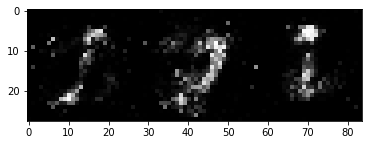

100%|██████████| 50/50 [09:19<00:00, 11.19s/it]


In [12]:
default_noise = torch.randn(batch_size, z_dim).to(device)
bceloss = nn.BCELoss()
for epoch in tqdm(range(num_epochs)):
    loss_gen = 0
    loss_disc = 0
    loss_gen = 0
    for batch_idx, (image, _) in enumerate(dataloader):
        image = image.view(-1, 28*28).to(device)
        d_real = discriminator(image).squeeze(-1)

        noise = torch.randn(batch_size, z_dim).to(device)
        fake = generator.forward(noise)
        d_fake = discriminator.forward(fake).squeeze(-1)

        # calculate loss function
        #discriminator
        loss_d = bceloss(d_real, torch.ones_like(d_real)) + bceloss(d_fake, torch.zeros_like(d_fake))
        loss_disc+=loss_d.detach().item()
        discriminator.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()

        #generator
        d_fake = discriminator.forward(fake).squeeze(-1)
        loss_g = bceloss(d_fake, torch.ones_like(d_fake))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        loss_gen+=loss_g.detach().item()
    clear_output()
    print(f'loss_gen={loss_gen/batch_size}, loss_disc={loss_disc/batch_size}')
    images = (generator.forward(default_noise).reshape(batch_size, 1, 28, 28)*0.5+0.5).cpu().detach().numpy()
    plt.imshow(np.concatenate(images[:, 0, :, :], axis=1)[:, :28*3], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()


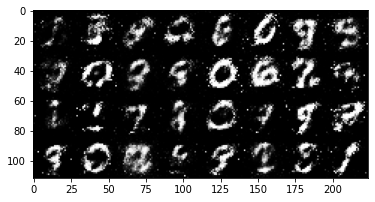

In [26]:
images = (generator.forward(default_noise).reshape(batch_size, 1, 28, 28)*0.5+0.5).cpu().detach().numpy()
ims = np.concatenate(np.concatenate(images[:, 0, :, :].reshape(8,4,28, 28), axis=2), axis=0)
plt.imshow(ims, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()